# CLUSTERING

Monitor: Juan Nicolas Piedrahita Salas

Introduccion a la inteligencia artificial 2023-01

## Importar librerias necesarias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Lectura de datos

#### este datset contiene informacion actualizada al 2021 sobre jugadores de la premier league

la limpieza de datos de este dataset fue realizada previamente, por lo que los datos vienen listos para usar

In [3]:
# Cargamos el dataset
datos = pd.read_csv("premier_league_2021_players.csv")

datos

,Name,Position,Goals,Losses,Assists,Red cards,Fouls,Appearances,Passes per match,Passes,Wins,Yellow cards
0,Sergio Reguilón,Defender,0.0,10.0,4.0,0.0,30.0,34.0,42.03,1429.0,17.0,5.0
1,Rhys Williams,Defender,0.0,1.0,0.0,0.0,4.0,9.0,56.00,504.0,7.0,0.0
2,Emerson Royal,Defender,0.0,3.0,0.0,0.0,5.0,4.0,33.00,132.0,1.0,0.0
3,Gary Cahill,Defender,28.0,135.0,11.0,3.0,278.0,394.0,34.17,13464.0,172.0,41.0
4,Mads Bech Sørensen,Defender,0.0,0.0,0.0,0.0,0.0,1.0,2.00,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
859,Pierre Lees-Melou,Midfielder,0.0,5.0,0.0,0.0,8.0,6.0,37.83,227.0,0.0,2.0
860,Adam Lallana,Midfielder,31.0,60.0,29.0,0.0,164.0,233.0,32.78,7637.0,108.0,18.0
861,Ilkay Gündogan,Midfielder,29.0,22.0,8.0,0.0,58.0,135.0,57.96,7825.0,99.0,15.0
862,Curtis Jones,Midfielder,3.0,6.0,3.0,0.0,23.0,33.0,35.73,1179.0,18.0,2.0


## exploracion de los datos

In [4]:
datos.describe()

,Goals,Losses,Assists,Red cards,Fouls,Appearances,Passes per match,Passes,Wins,Yellow cards
count,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
mean,5.932870,19.524306,4.053241,0.237269,41.394676,54.921296,19.780208,1809.797454,22.608796,6.113426
std,16.279856,29.006882,9.068016,0.644398,71.220354,81.000656,19.140087,2917.977835,36.730609,10.840083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.000000,0.000000,0.000000,4.000000,14.000000,18.045000,274.000000,4.000000,1.000000
75%,4.000000,28.000000,3.000000,0.000000,51.000000,78.000000,32.800000,2525.750000,31.000000,8.000000
max,184.000000,164.000000,85.000000,5.000000,467.000000,567.000000,83.620000,18255.000000,286.000000,82.000000


podemos graficar las distribuciones y correlaciones de los datos, para tener una idea de como se comportan

In [5]:
# funcion para graficar la correlacion y la distribucion entre variables numericas
def plot_pares(df):
    import matplotlib.pyplot as plt
    import seaborn as sb
    import numpy as np

    num_cols = df.select_dtypes(include=np.number).columns

    # matriz de correlaciones
    grid = sb.pairplot(
        df,
        height=2, 
        vars=num_cols,
        kind='scatter'
    )

    def pintarCorr(x, y, **kwargs):
        plt.gca().get_children()[0].remove()

        # calcular correlacion de pearson
        corr = round(np.corrcoef(x, y)[0,1], 2)
        plt.gca().text((max(x) + min(x))/2, (max(y) + min(y))/2, s=str(corr), fontsize=12)


    # pintar la correlacion en la parte inferior de la diagonal
    grid.map_lower(pintarCorr)

    plt.show()

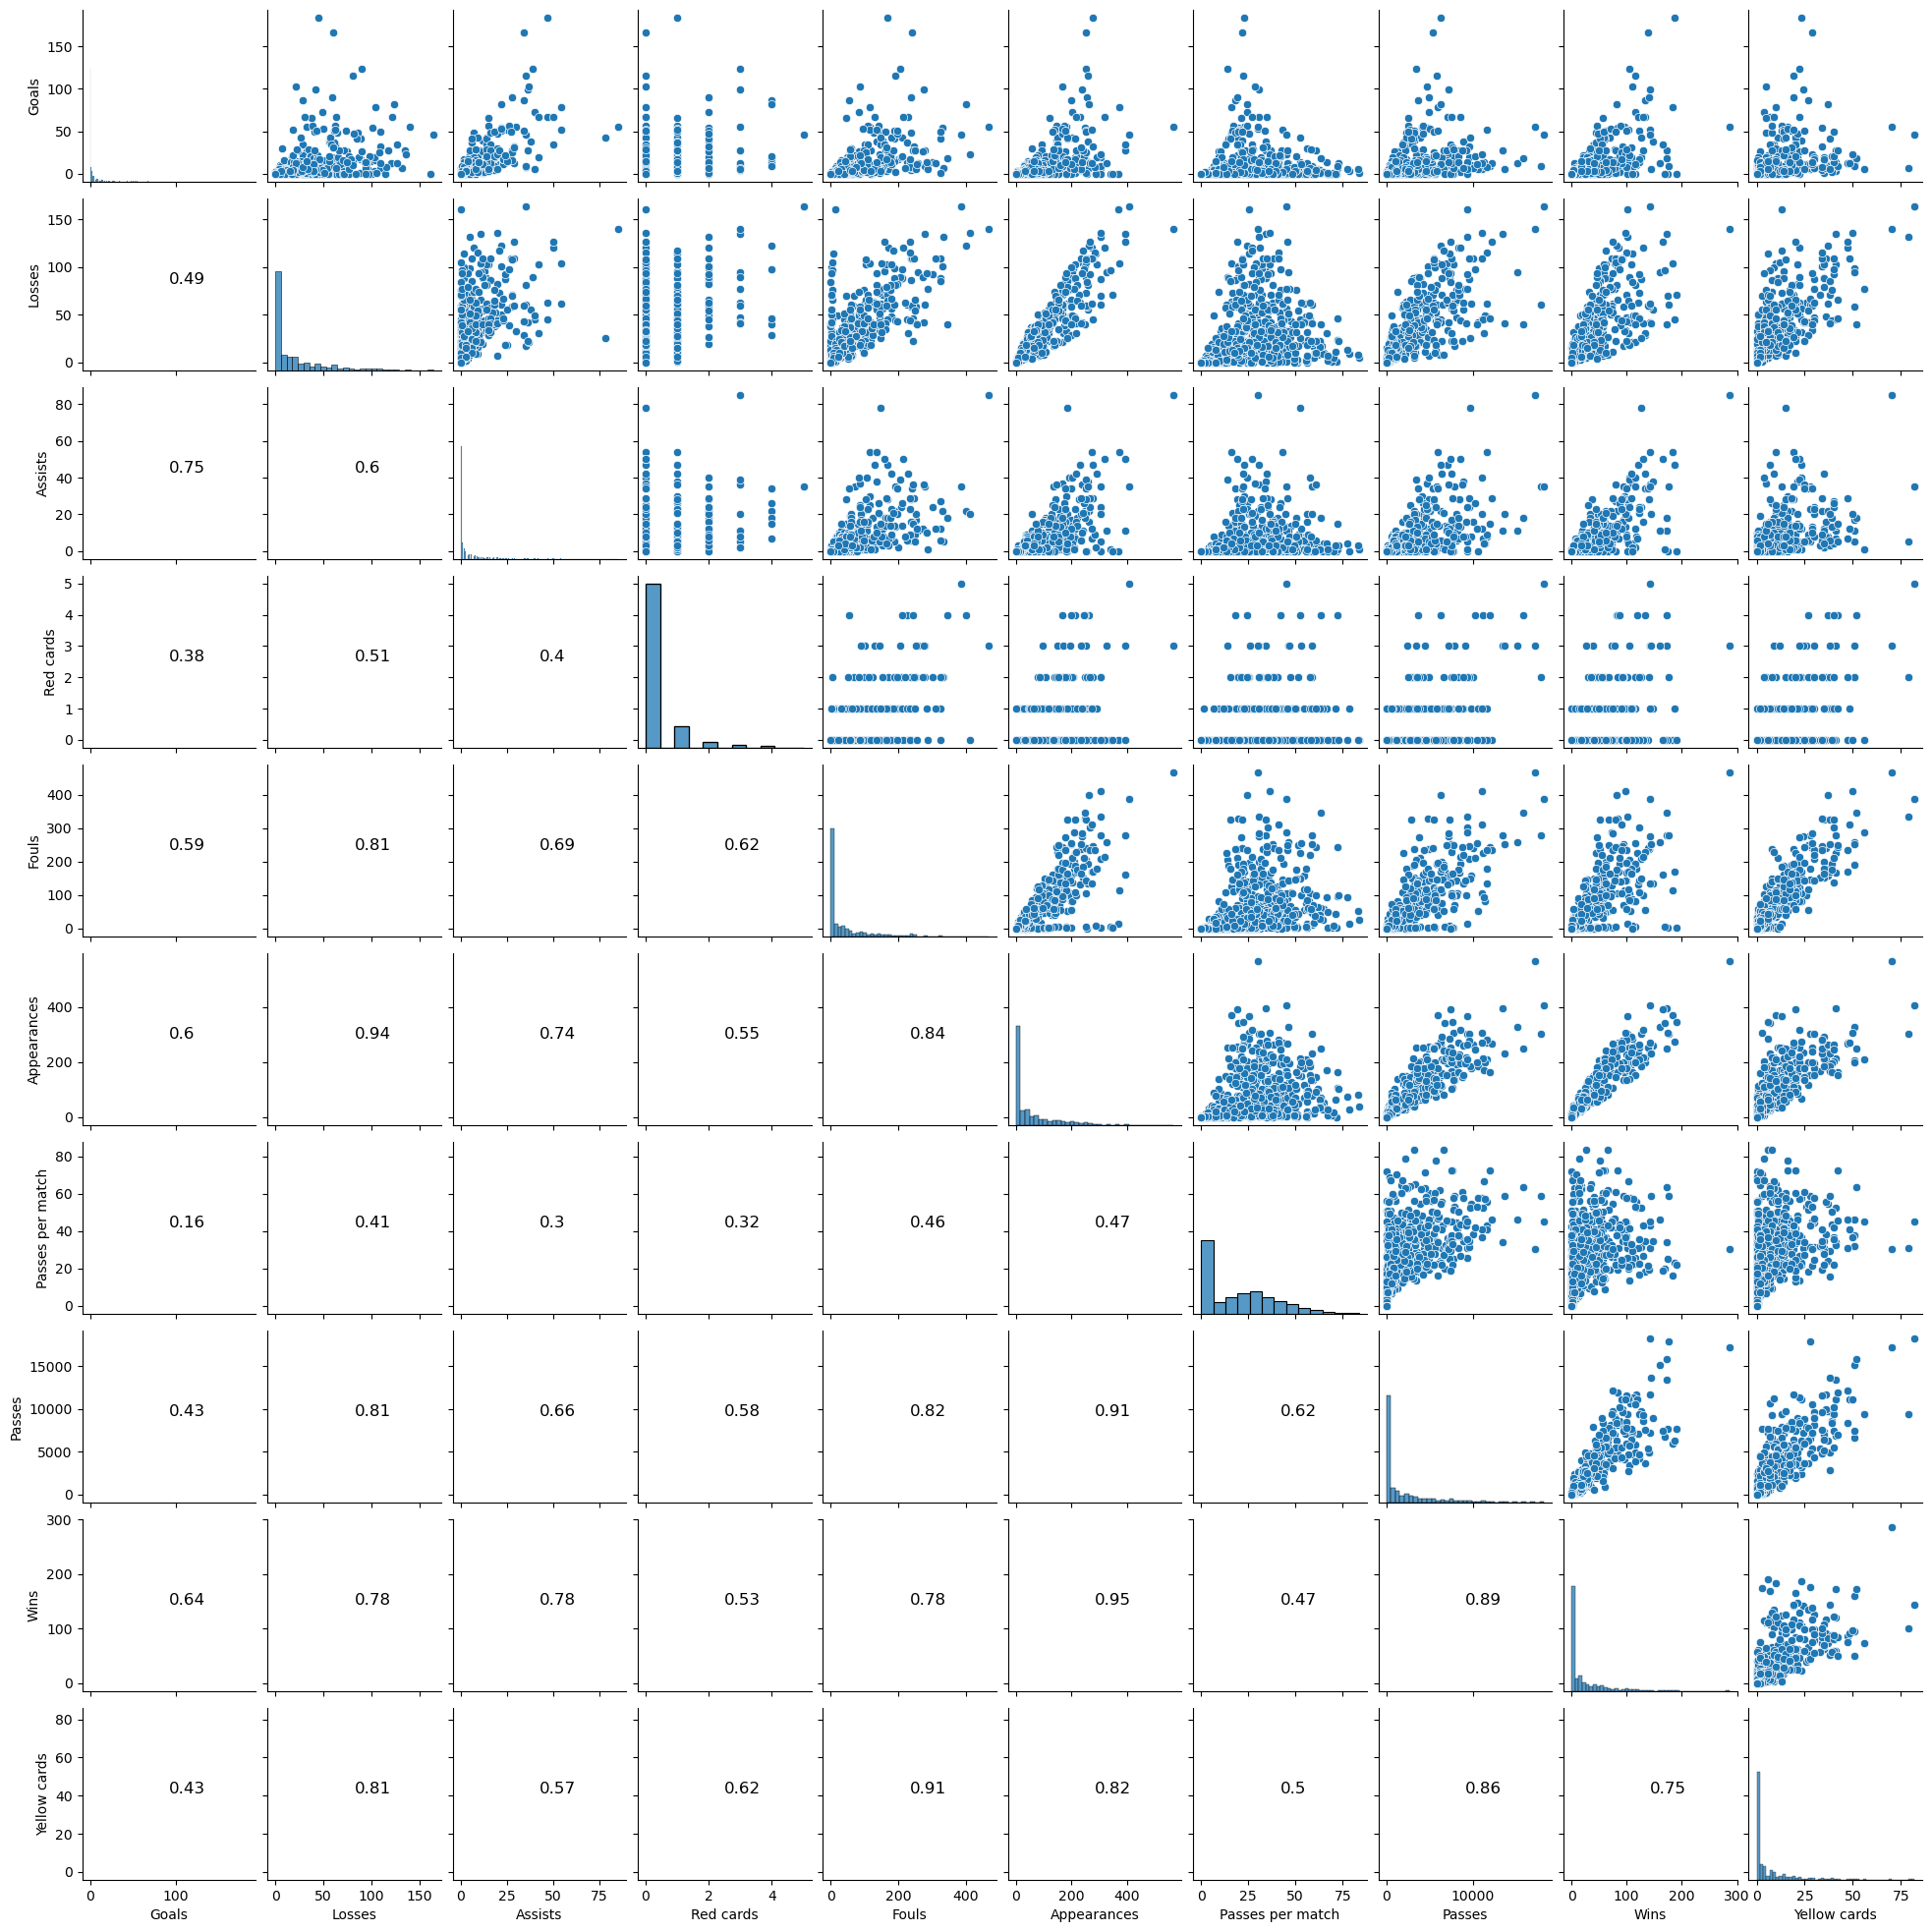

In [6]:
plot_pares(datos)

la grafica nos muestra graficos por pares, las distribuciones y las correlaciones lineales de las variables numericas, este grafico nos permite entender como se relacionan las variables entre si

#### escalamos las datos para que esten en el mismo rango [0, 1]
para todos los algoritmos basados en distancias debemos escalar los datos al mismo rango, para evitar que hayan variables que tengan mayor influencia a la hora de calcular las distancias entre puntos, en este caso usaremos `MinMaxScaler` de la libreria `sklearn`

en este ejemplo escogeremos 3 columnas para hacer el clustering, de modo que las podamos graficar en un grafico 3D

In [84]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(datos[["Goals", "Assists", "Passes"]])

scaled_data

array([[0.        , 0.04705882, 0.07827992],
       [0.        , 0.        , 0.02760887],
       [0.        , 0.        , 0.0072309 ],
       ...,
       [0.1576087 , 0.09411765, 0.42864969],
       [0.01630435, 0.03529412, 0.06458505],
       [0.        , 0.        , 0.        ]])

### evaluamos la cantidad optima de clusters

#### elbow curve

In [8]:
def elbow_curve(data, maxClusters = 15):
  from sklearn.cluster import KMeans
  
  # rango de valores del parámetro a optimizar (cantidad de clusters)
  maxClusters = range(1, maxClusters + 1)

  # se ejecuta el modelo para el rango de clusters y se guarda la inercia
  # respectiva obtenida para cada valor
  inertias = []
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k, n_init="auto")
    kmeanModel.fit(data)
    inertias.append(kmeanModel.inertia_)

  # Grafico de los resultados obtenidos para cada valor del rango
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('Curva de codo')
  plt.show()

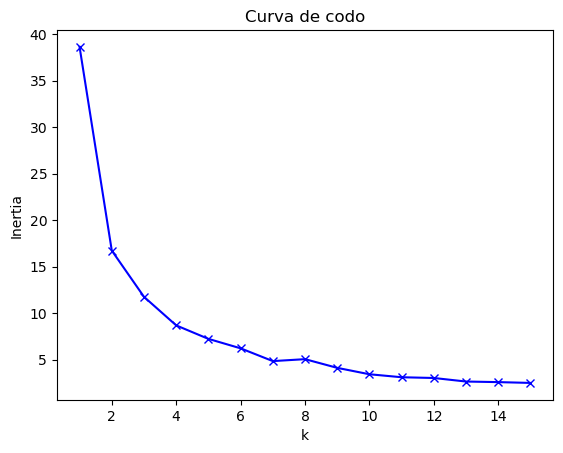

In [9]:
elbow_curve(scaled_data)

#### Estadistico de GAP

In [10]:
# nrefs es la cantidad de datos ("datasets") de referencia contra los que se va a comparar
def GAPstatistic(data, maxClusters=15, nrefs=3):
    from sklearn.cluster import KMeans
    
    gaps = np.zeros((maxClusters,))
    results = {'clusterCount':[], 'gap':[]}
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        # guardara los resultados de dispersión de cada distribución simulada
        refDisps = np.zeros(nrefs)

        # Genera las muestras aleatorias indicadas con nrefs y ejecuta k-means
        # en cada bucle obteniendo los resultados de dispersión (inercia)
        # para cada conjunto generado.
        for i in range(nrefs):
            
            # Crea nuevo conjunto aleatorio de referencia
            # Se puede usar una semilla para tener reproducibilidad
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)
            
            # se ajusta el modelo al conjunto de referencia
            km = KMeans(k, n_init="auto")
            km.fit(randomReference)
            # se guarda la dispersión obtenida
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Se ajusta el modelo a los datos originales y se guarda su inercia
        km = KMeans(k, n_init="auto")
        km.fit(data)
        
        origDisp = km.inertia_

        # Calcula el estadístico de gap para k clusters usando el promedio de
        # las dispersiones de los datos simulados y la dispersión de los datos originales.
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Guarda el estadístico de gap obtenido en este bucle.
        gaps[gap_index] = gap
        
        results['clusterCount'].append(k)
        results['gap'].append(gap)

    # Selecciona el "primer máximo" de los estadísticos obtenidos y devuelve 
    # su respectivo número de clusters    
    for i in range(0, len(gaps)-1):
      if gaps[i+1] <= gaps[i]:
        optK = i+1
        break
    
    plt.figure()

    plt.plot(results['clusterCount'], results['gap'], linewidth=3, marker='o')
    plt.axvline(x=optK, color='r', linestyle='--')

    plt.xlabel('Cantidad de clusters')
    plt.ylabel('Gap')
    plt.title('Estadístico de gap')
    plt.show()

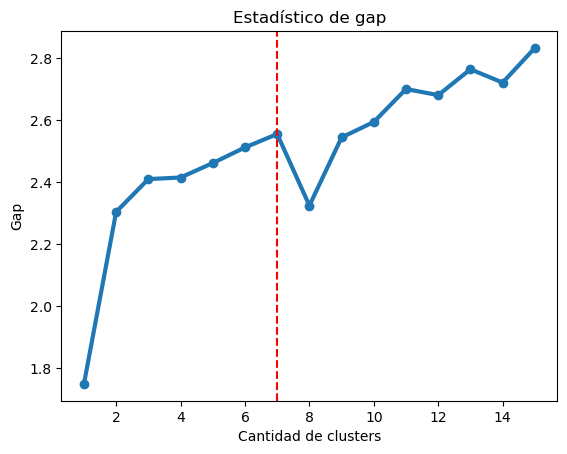

In [11]:
GAPstatistic(scaled_data)

#### Coeficiente de silueta

### Dendograma

In [12]:
def Dendograma(data, lines=[]):
    import scipy.cluster.hierarchy as shc

    plt.figure(figsize=(15, 7))  
    plt.title("Dendrograma") 
    dend = shc.dendrogram(shc.linkage(data, method='ward'),truncate_mode='level',p=3)

    for l in lines:
        plt.axhline(y=l, color='b', linestyle='-.')
    
    plt.ylabel('Distancia euclidiana')
    plt.xlabel('puntos de datos')
    plt.show()

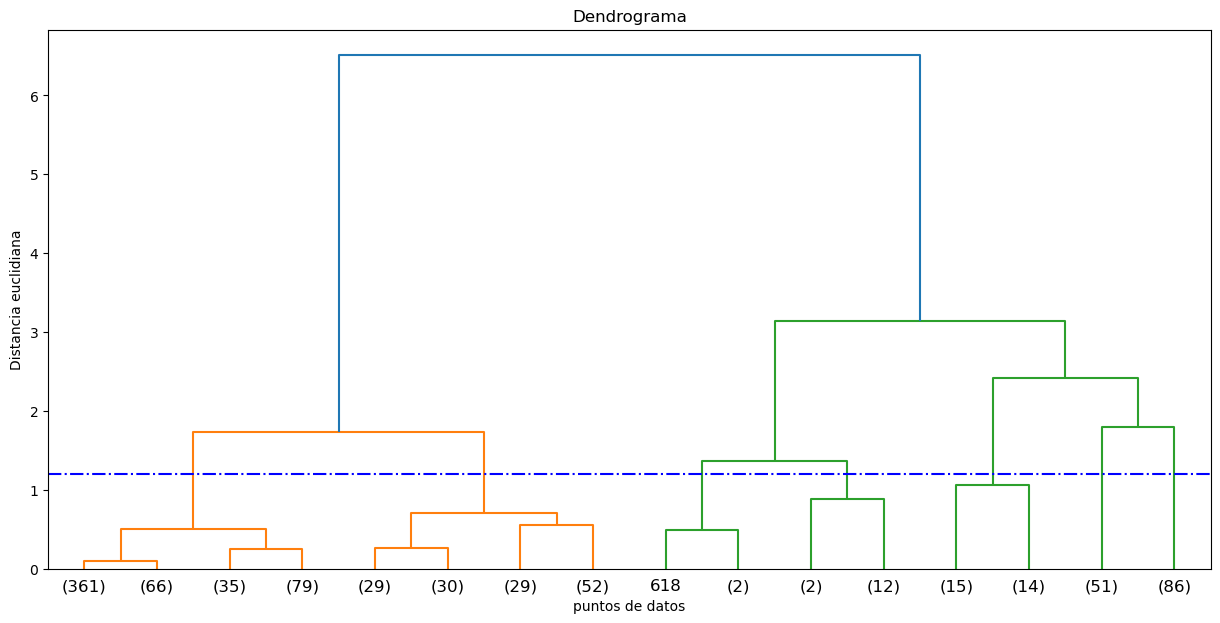

In [13]:
Dendograma(scaled_data, [1.2])

### clustering jerarquico aglomerativo

usaremos la clase `AgglomerativeClustering` de la libreria `sklearn`

In [14]:
from sklearn.cluster import AgglomerativeClustering

aggClusters = AgglomerativeClustering(n_clusters=7)
aggClusters = aggClusters.fit(scaled_data)

### clustering k-means

usaremos la clase `KMeans` de la libreria `sklearn`

In [15]:
from sklearn.cluster import KMeans

KmeansClusters = KMeans(n_clusters=7, n_init="auto")
KmeansClusters = KmeansClusters.fit(scaled_data)

### comparacion entre metodos

jugadores que fueron clasificados diferentes

In [16]:
print("numero de jugadores que fueron clasificados diferentes =", np.sum(aggClusters.labels_ != KmeansClusters.labels_))

numero de jugadores que fueron clasificados diferentes = 864


conteo por clase

In [17]:
display(
    "AgglomerativeClustering",
    pd.Series(aggClusters.labels_).value_counts(),
    "KMeans",
    pd.Series(KmeansClusters.labels_).value_counts()
)

'AgglomerativeClustering'

5    541
2    140
0     86
4     51
1     29
3     14
6      3
dtype: int64

'KMeans'

0    554
6    148
1     69
3     43
2     29
5     11
4     10
dtype: int64

### Caracterizacion de los datos por cluster

In [18]:
datos["cluster"] = aggClusters.labels_

In [19]:
from plotly.express import scatter_3d

fig = scatter_3d(
    datos,
    x="Goals",
    y="Assists",
    z="Passes",
    color="cluster",
)

fig.show()

#### graficar la media de cada variable por cluster

C:\Users\jnico\AppData\Local\Temp\ipykernel_4528\3103933527.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



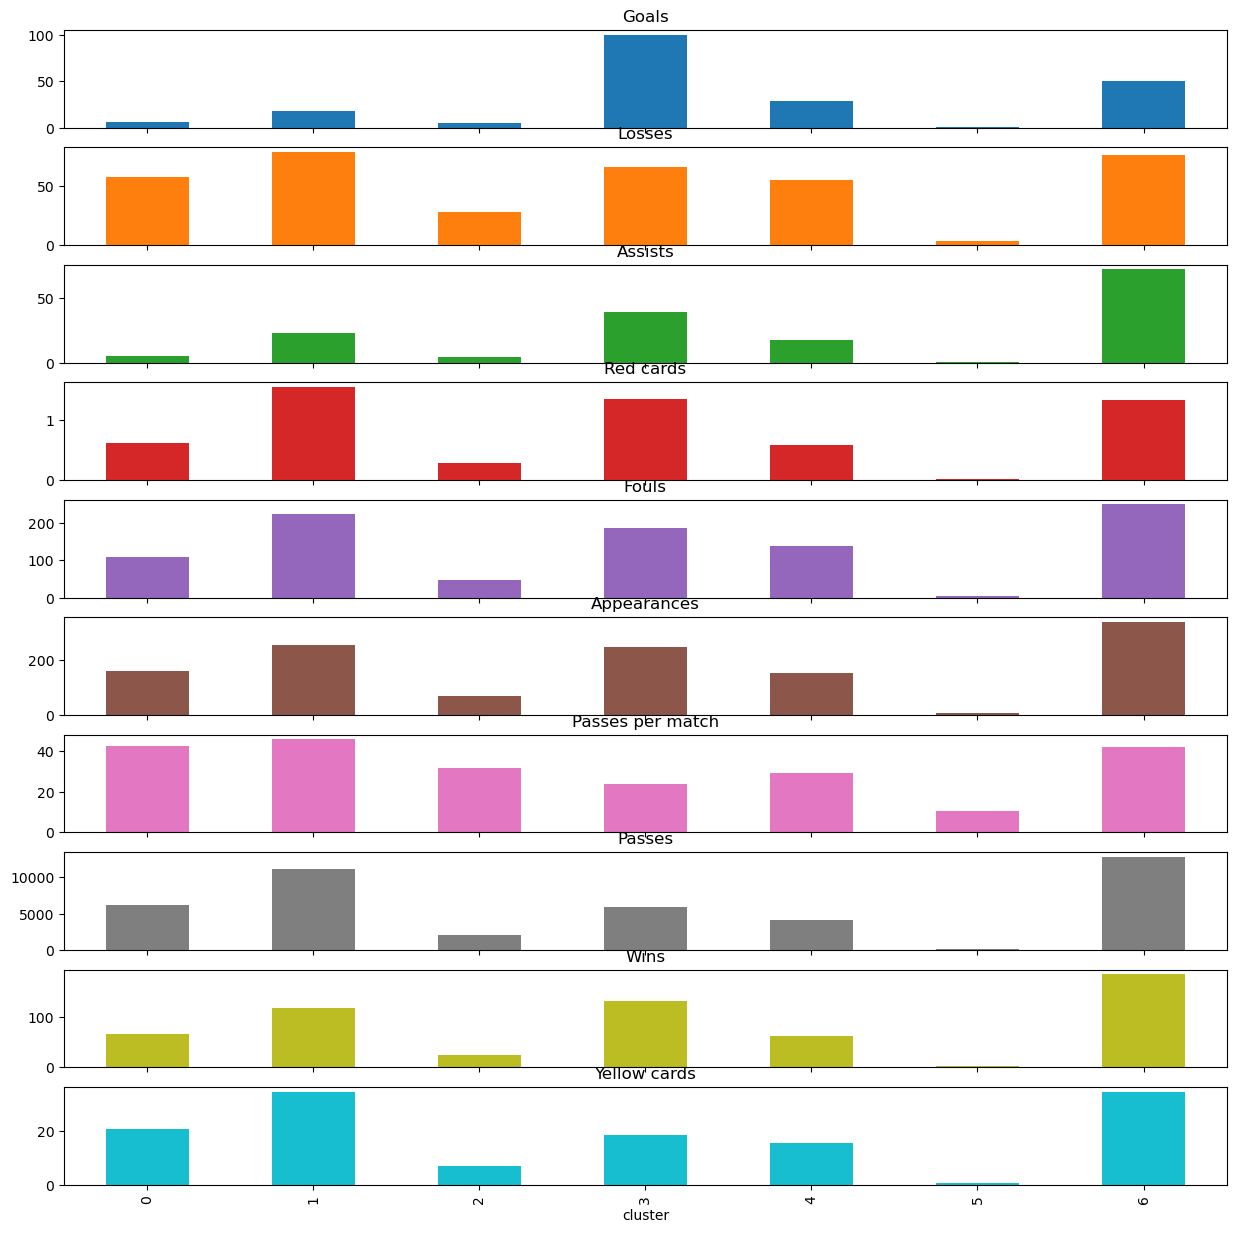

In [43]:
grouped_data = datos.groupby("cluster").mean()

grouped_data.plot.bar(subplots=True, figsize=(15, 15), legend=False)

plt.show()

#### Podemos ver un las estadisticas de un jugador en especifico

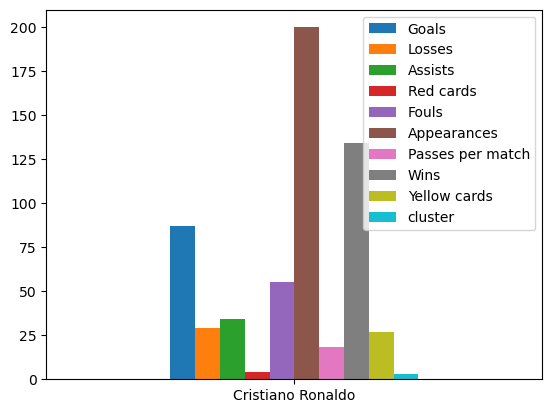

In [38]:
datos.loc[datos["Name"].str.contains("Cristiano"), datos.columns.drop("Passes")].plot.bar()

plt.xticks(ticks=plt.gca().get_xticks(), labels=["Cristiano Ronaldo"], rotation=0)
plt.show()

#### ejemplos de jugados por cluster

In [39]:
datos.groupby("cluster")["Name"].apply(lambda player: ", ".join(player[:5]))

cluster
0    Harry Maguire, Lewis Dunk, Craig Dawson, Ahmed...
1    Gary Cahill, Eric Dier, Andrew Robertson, Toby...
2    Sergio Reguilón, Ben Gibson, Issa Diop, Timoth...
3    Sadio Mané, Theo Walcott, Cristiano Ronaldo, M...
4    Matt Targett, Cédric Soares, Ben Chilwell, Aar...
5    Rhys Williams, Emerson Royal, Mads Bech Sørens...
6             Juan Mata, James Milner, Kevin De Bruyne
Name: Name, dtype: object

#### ejemplos de jugador por cluster y posicion

In [40]:
datos.groupby(["cluster", "Position"])["Name"].apply(lambda player: ", ".join(player[:5]))

cluster  Position  
0        Defender      Harry Maguire, Lewis Dunk, Craig Dawson, Ahmed...
         Goalkeeper    Hugo Lloris, Ederson, Lukasz Fabianski, Ben Fo...
         Midfielder    Romain Saïss, Mohamed Elneny, Wilfred Ndidi, J...
1        Defender      Gary Cahill, Eric Dier, Andrew Robertson, Toby...
         Forward                                                 Willian
         Midfielder    Marc Albrighton, Fernandinho, Granit Xhaka, Ro...
2        Defender      Sergio Reguilón, Ben Gibson, Issa Diop, Timoth...
         Forward       Dwight Gayle, Steven Bergwijn, Hélder Costa, T...
         Goalkeeper    Scott Carson, John Ruddy, Alisson, Jack Butlan...
         Midfielder    Ruben Loftus-Cheek, Josh Brownhill, Phil Foden...
3        Forward       Sadio Mané, Theo Walcott, Cristiano Ronaldo, M...
         Midfielder                                     Gylfi Sigurdsson
4        Defender      Matt Targett, Cédric Soares, Ben Chilwell, Aar...
         Forward       Ayoze Pé

### prediccion de cluster de un nuevo jugador

##### para predecir el cluster de un nuevo jugador debemos seguir los mismos pasos que para el clustering, es decir, escalar los datos y aplicar el algoritmo de clustering

no podemos hacer predicciones con el metodo aglomerativo, ya que el añadir un nuevo punto puede cambiar completamente el como se generan los clusters en este metodo

In [44]:
datos[["Goals", "Assists", "Passes"]].describe()

,Goals,Assists,Passes
count,864.000000,864.000000,864.000000
mean,5.932870,4.053241,1809.797454
std,16.279856,9.068016,2917.977835
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,274.000000
75%,4.000000,3.000000,2525.750000
max,184.000000,85.000000,18255.000000


In [93]:
jugador_nuevo = [np.random.uniform(0, 180), np.random.uniform(0, 80), np.random.uniform(0, 18000)]
jugador_nuevo = scaler.transform([jugador_nuevo])

print("jugador nuevo =", scaler.inverse_transform(jugador_nuevo)[0])
print("cluster asignado al jugador nuevo =", KmeansClusters.predict(jugador_nuevo)[0])

jugador nuevo = [   90.26121136    11.17660109 10863.21679189]
cluster asignado al jugador nuevo = 2


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

